In [2]:
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import seaborn as sns
import matplotlib.pyplot as plt
# sns.set_theme()
import pandas as pd

## Regression

In [3]:
# Let us generate some data
x = np.random.normal(2, 0.4, size=10000)

def f1(x):
    error = np.random.normal(0, 0.2, size = len(x))
    return -0.4 + 2*x + error

def f2(x):
    error = np.random.normal(0, 0.2, size = len(x))
    intercept = np.random.normal(-0.4, 0.1, size = len(x))
    return intercept + 2*x + error

y1 = f1(x)

In [4]:
df1 = pd.DataFrame(data={'x': x, 'y': y1})

In [36]:
sns.displot(df1);

AttributeError: module 'seaborn' has no attribute 'displot'

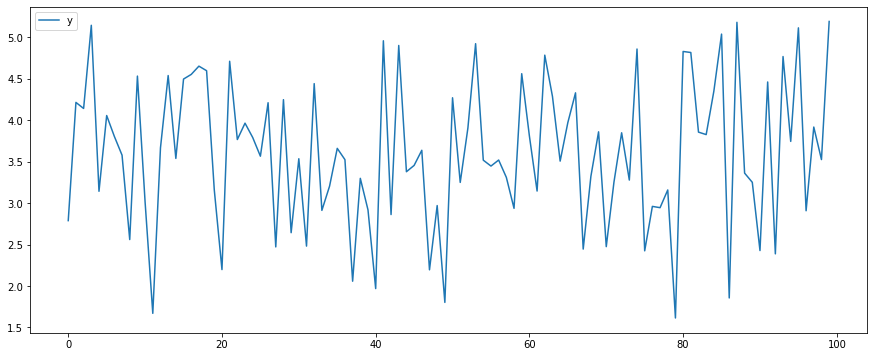

In [6]:
plt.figure(figsize=(15,6))
sns.lineplot(data=df1[0:100]);

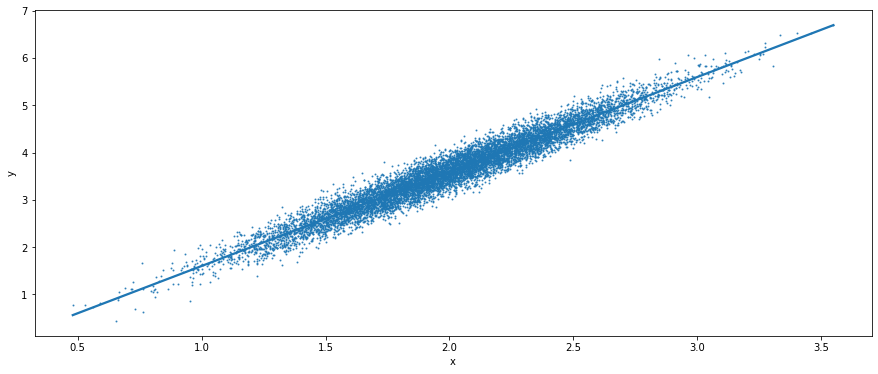

In [7]:
plt.figure(figsize=(15,6))
sns.regplot(x="x", y="y", data=df1, scatter_kws={'s':1});

In [8]:
model_input = sm.add_constant(x)
model = sm.OLS(y1, model_input).fit()

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                 1.592e+05
Date:                Fri, 30 Oct 2020   Prob (F-statistic):               0.00
Time:                        10:58:20   Log-Likelihood:                 1881.2
No. Observations:               10000   AIC:                            -3758.
Df Residuals:                    9998   BIC:                            -3744.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3968      0.010    -38.770      0.000      -0.417      -0.377
x1             1.9983      0.005    398.962      0.000       1.988       2.008
==============================================================================
Omnibus:                        1.050   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.591   Jarque-Bera (JB):                1.081
Skew:                           0.017   Prob(JB):                        0.582
Kurtosis:                       2.961   Cond. No.                         12.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

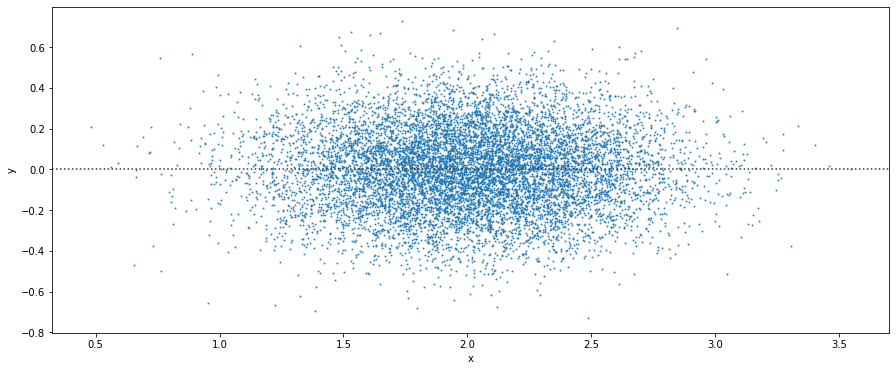

In [9]:
plt.figure(figsize=(15,6))
sns.residplot(x="x", y="y", data=df1, scatter_kws={'s':1});

## Stochastic process

In [10]:
def p1(mu, std, length):
    realisation = [np.random.normal(mu, std) for t in range(length)]
    return realisation

In [11]:
time_length = 100
num_realisations = 1000
realisations = {f"r{i}":p1(2, 0.1, time_length) for i in range(num_realisations)}
df = pd.DataFrame(data=realisations)

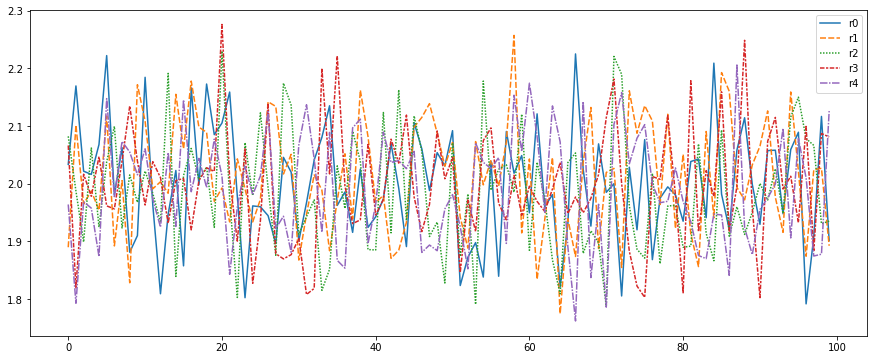

In [12]:
subset_df = df.iloc[:, 0:5]
plt.figure(figsize=(15,6))
sns.lineplot(data=subset_df);

AttributeError: module 'seaborn' has no attribute 'histplot'

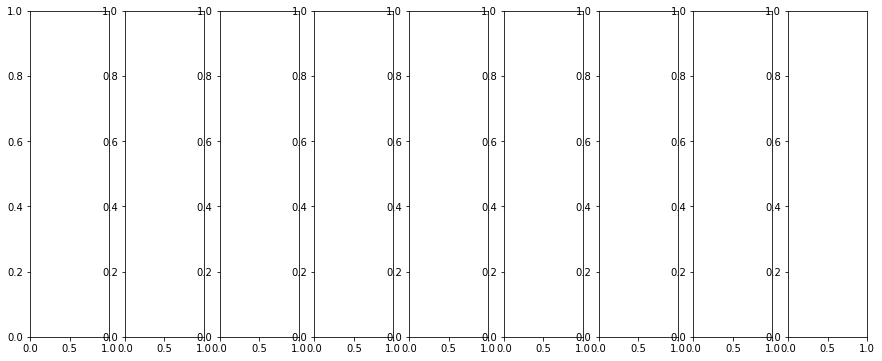

In [35]:
fig, axs = plt.subplots(ncols=9,figsize=(15,6))
ax_idx = 0
for i in range(0, time_length, int(time_length/8)):
    sns.histplot(df.loc[i], ax=axs[ax_idx])
    ax_idx += 1

### Checking conditions of (weak) stationarity

In [ ]:
means = []
stdevs = []
for i in range(0, time_length, int(time_length/8)):
    mean = np.mean(df.loc[i])
    std = np.std(df.loc[i])
    means.append(mean)
    stdevs.append(std)

covars = []
lag = 7
for i in range(0, time_length - lag, lag):
    covar = np.cov(df.loc[i], df.loc[i+lag])[0][1]
    covars.append(covar)

In [ ]:
covars

## Non-stationarity

In [14]:
def rw(length, beta_1=0, beta_2=0, beta_3=1):
    realisation = [beta_1]
    [realisation.append(beta_1 + beta_2*t + beta_3*realisation[t-1] + np.random.normal(0,0.1)) for t in range(1, length)]
    return np.array(realisation)

In [15]:
# Random Walk with/without Drift
drift = 0
time_factor = 0
beta_3 = 0.95
time_length = 100
num_realisations = 1000
realisations = {f"r{i}":rw(time_length, beta_1=drift, beta_2=time_factor, beta_3=beta_3) for i in range(num_realisations)}
df = pd.DataFrame(data=realisations)

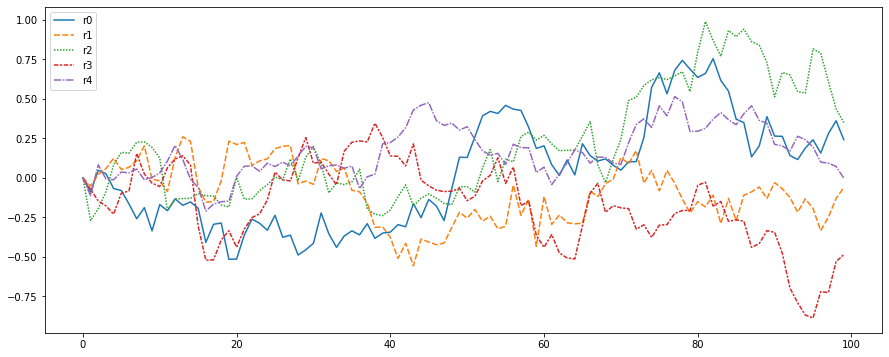

In [16]:
subset_df = df.iloc[:, 0:5]
plt.figure(figsize=(15,6))
sns.lineplot(data=subset_df);

AttributeError: module 'seaborn' has no attribute 'histplot'

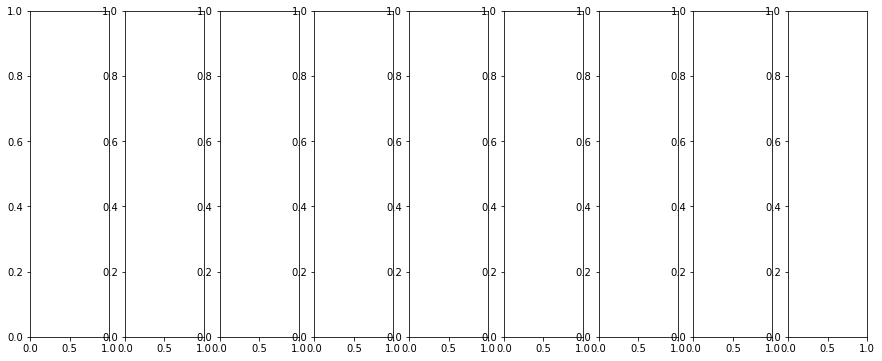

In [17]:
fig, axs = plt.subplots(ncols=9,figsize=(15,6))
ax_idx = 0
for i in range(1, time_length, int(time_length/8)):
    sns.histplot(df.loc[i], ax=axs[ax_idx])
    ax_idx += 1

In [ ]:
means = []
stdevs = []
for i in range(0, time_length, int(time_length/8)):
    mean = np.mean(df.loc[i])
    std = np.std(df.loc[i])
    means.append(mean)
    stdevs.append(std)

covars = []
lag = 5
for i in range(0, time_length - lag, lag):
    covar = np.cov(df.loc[i], df.loc[i+lag])[0][1]
    covars.append(covar)

In [ ]:
stdevs

### ADF Tests for stationarity
$H_0$: The series has a unit root (time series is not stationary).

$H_1$: The series has no unit root (time series is stationary).

In [18]:
def adf_test(timeseries, regression="nc"):
    """
    regression can be "nc", "c", "ct"
    """
    print ('Results of Dickey-Fuller Test:')
    test_output = adfuller(timeseries, autolag='AIC', regression=regression)
    output = pd.Series(test_output[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print (output)

In [19]:
realisation = df["r0"]
adf_test(realisation)

Results of Dickey-Fuller Test:
Test Statistic                 -1.473008
p-value                         0.131702
#Lags Used                      0.000000
Number of Observations Used    99.000000
dtype: float64


## Spurious Regression

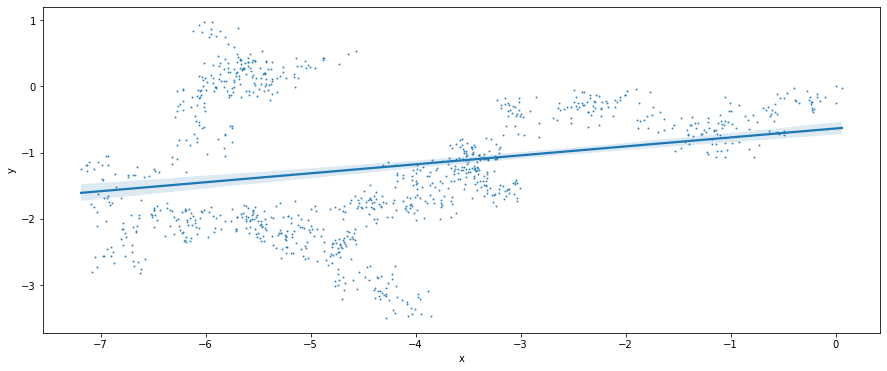

In [20]:
x = rw(1000, beta_1=0, beta_2=0, beta_3=1)
y = rw(1000, beta_1=0, beta_2=0, beta_3=1)

df_s = pd.DataFrame(data = {"x":x, "y":y})
#sns.lineplot(data=df);
plt.figure(figsize=(15,6))
sns.regplot(x="x", y="y", data=df_s, scatter_kws={'s':1});

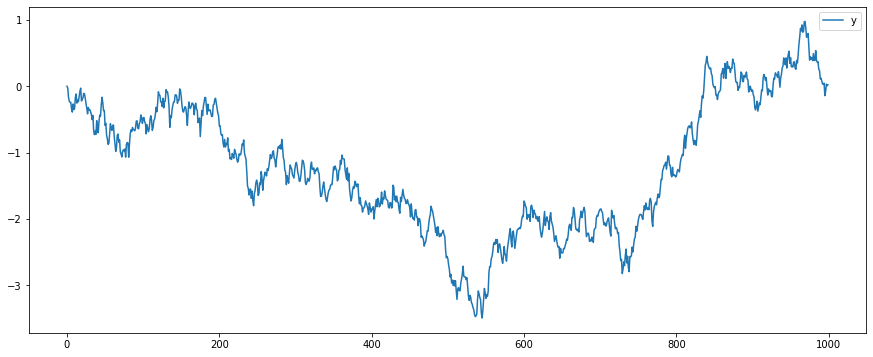

In [21]:
plt.figure(figsize=(15,6))
sns.lineplot(data=df_s);

In [22]:
model_input = sm.add_constant(df_s['x'])
model = sm.OLS(df_s['y'], model_input).fit()

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     60.05
Date:                Fri, 30 Oct 2020   Prob (F-statistic):           2.27e-14
Time:                        10:58:26   Log-Likelihood:                -1373.3
No. Observations:                1000   AIC:                             2751.
Df Residuals:                     998   BIC:                             2760.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6362      0.081     -7.837      0.000      -0.795      -0.477
x              0.1352      0.017      7.749      0.000       0.101       0.169
==============================================================================
Omnibus:                       16.534   Durbin-Watson:                   0.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               15.051
Skew:                           0.250   Prob(JB):                     0.000539
Kurtosis:                       2.665   Cond. No.                         13.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Cointegration

In [23]:
x = rw(1000, beta_1=0, beta_2=0, beta_3=1)
df = pd.DataFrame(data = {'x': x})
df['diff_x'] = df['x'].diff(periods=1)

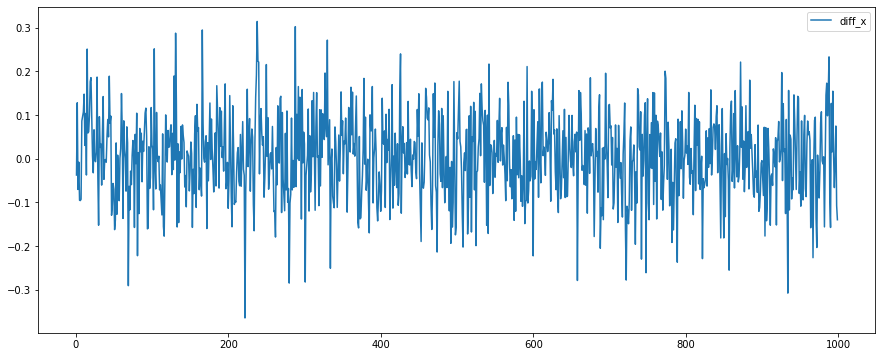

In [24]:
plt.figure(figsize=(15,6))
sns.lineplot(data=df);

In [25]:
adf_test(df['diff_x'][1:])

Results of Dickey-Fuller Test:
Test Statistic                 -20.256505
p-value                          0.000000
#Lags Used                       1.000000
Number of Observations Used    997.000000
dtype: float64


### Spurious regression example

In [26]:
df_s['diff_x'] = df_s['x'].diff(periods=1)
df_s['diff_y'] = df_s['y'].diff(periods=1)


model_input = sm.add_constant(df_s['diff_x'][1:])
model = sm.OLS(df_s['diff_y'][1:], model_input).fit()

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 diff_y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                  0.006453
Date:                Fri, 30 Oct 2020   Prob (F-statistic):              0.936
Time:                        10:58:27   Log-Likelihood:                 915.38
No. Observations:                 999   AIC:                            -1827.
Df Residuals:                     997   BIC:                            -1817.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.119e-06      0.003      0.002      0.998      -0.006       0.006
diff_x        -0.0025      0.031     -0.080      0.936      -0.063       0.058
==============================================================================
Omnibus:                        0.408   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.816   Jarque-Bera (JB):                0.327
Skew:                           0.038   Prob(JB):                        0.849
Kurtosis:                       3.046   Cond. No.                         10.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Cointegrated series
$H_0$: no cointegration
$H_1$: cointegrating relationship exists

In [27]:
x1 = rw(1000, beta_1=0, beta_2=0, beta_3=1)
x2 = 1.2 * x1 + np.random.normal(0, 0.2, size = len(x1))
df = pd.DataFrame(data={'x1':x1, 'x2': x2})

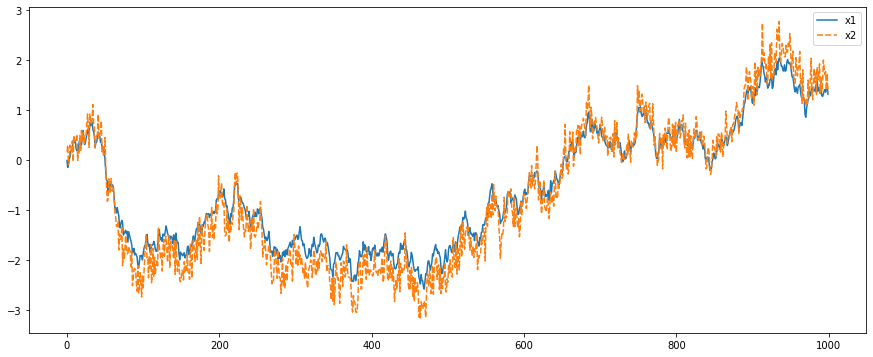

In [28]:
plt.figure(figsize=(15,6))
sns.lineplot(data=df);

In [29]:
_,p_value,_ = coint(x1, x2)
p_value

0.0

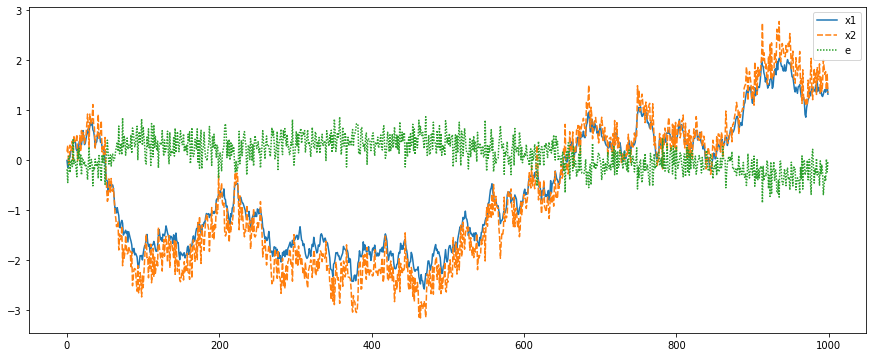

In [30]:
df['e'] = df['x1'] - df['x2']
plt.figure(figsize=(15,6))
sns.lineplot(data=df);